# Plots some statistics / Quality evaluation from the segmented data
## Planar fit from legs and Roll/W correlation outside legs

Includes code for control runs from LIAISE

In [5]:
import sys
import os
from utils import *

# Planar fit all the data

In [6]:
from scipy.spatial.transform import Rotation as R

def process_campaign_planar(campaign, INS, data_root='../../Data',alpha_b=0.0, beta_b=0.0, roll_b=0.0, pitch_b=0.0,yaw_b=0):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []
    stats = []
    all_inside = []
    all_outside = []
    final_summary = []
    delta_phi = roll_b
    delta_head = yaw_b
    delta_pit = pitch_b

    # Function to apply roll perturbation to a single row
    def apply_roll_perturbation_inplace(row):
        """
        Applies a roll perturbation (delta_phi) to a given row representing orientation in ZYX Euler angles.
        
        Parameters:
        - row (dict-like): Should contain 'HEADING', 'PITCH', 'ROLL' in degrees.
        - delta_phi (float): Roll perturbation angle in degrees.
        
        Returns:
        - row (dict-like): Updated row with modified 'HEADING', 'PITCH', 'ROLL'.
        """
        # Original orientation
        r_orig = R.from_euler('ZYX', [row['HEADING'], row['PITCH'], row['ROLL']], degrees=True)
        
        # Perturbation rotation around ZYX (roll)
        r_delta = R.from_euler('ZYX', [delta_head, delta_pit, delta_phi], degrees=True)
        
        # Apply perturbation
        r_new = r_delta * r_orig
        
        # Convert back to Euler angles
        yaw_new, pitch_new, roll_new = r_new.as_euler('ZYX', degrees=True)
        
        # Update in place
        row['HEADING'] = np.float32(yaw_new)
        row['PITCH'] = np.float32(pitch_new)
        row['ROLL'] = np.float32(roll_new)
        
        return row
    
    

    #print(f"Looking in: {segmentation_dir}")
    #print("Files found:", os.listdir(segmentation_dir))
    # Define a function to calculate the residuals for least squares fitting
    def residuals(params, u, v, w):
        a, b, c = params
        return w - (a * u + b * v + c)
    
    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        #print(f'Flight {flight_number}')
        if flight_number is None:
            continue
            
        if flight_number < 200009 and campaign == 'EUREC4A':
            print(f'Skipping bad EUREC4A flight {flight_number}')
            continue
        #print(f'Processing flight {flight_number}...')
        yaml_path = os.path.join(segmentation_dir, fname)

        # Match raw data folder
        matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                               if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
        if not matching_raw_folder:
            print(f"No raw folder found for {campaign} {INS}")
            continue

        raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
        # Look for any .nc file containing the flight number
        flight_str = f'{flight_number:02d}'
        nc_candidates = [f for f in os.listdir(raw_folder)
                         if f.endswith('.nc') and flight_str in f]
        
        if not nc_candidates:
            print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
            continue
        
        nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
        #print(f"  - Loading NetCDF: {nc_candidates[0]}")

        yaml_data = read_yaml(yaml_path)
        df_raw = load_raw_data(nc_path)
        if 'SIDESLIP_RAD' in df_raw.columns:
            df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
        # Resampling to reduce computations (prevents memory shortage)
        df_raw = df_raw[['NORTH_SPEED','EAST_SPEED','VERTICAL_SPEED',
                         'ROLL','PITCH','HEADING',
                         'AOA_RAD','AOS_RAD','TAS',
                         'EASTWARD_WIND','NORTHWARD_WIND','VERTICAL_WIND']].resample('1s').mean()
        # Wind recomputation
        # Apply and overwrite original columns
        df_raw = df_raw.dropna()
        df_raw = df_raw.apply(apply_roll_perturbation_inplace, axis=1)
        U,V,W = wind_computation_bias(df_raw, aoa_bias = -alpha_b, aos_bias = -beta_b)
        df_raw['W']= W
        df_raw['U_WIND'] = U
        df_raw['V_WIND'] = V
        # Plane frame of reference
        df_raw[['U_L', 'V_T']] = df_raw.apply(wind_to_body_frame, axis=1)
        # Initialize segment mask
        mask_all_segments = pd.Series(False, index=df_raw.index)
        for seg in yaml_data['subsegments']:
            start = pd.to_datetime(seg['start'])
            end = pd.to_datetime(seg['end'])
            df_segment = df_raw[(df_raw.index >= start) & (df_raw.index <= end)]
            mask_all_segments |= (df_raw.index >= start) & (df_raw.index <= end)

        df_outside = df_raw[~mask_all_segments]
        df_inside = df_raw[mask_all_segments]
        all_inside.append(df_inside)
        all_outside.append(df_outside)
        results_inside = []
        results_outside = []
        results_all = []

    df_inside = pd.concat(all_inside)
    df_outside = pd.concat(all_outside)
    df_raw = pd.concat([df_inside,df_outside])
    str_ad = ['Inside','Outside','All']

    df_prep=df_inside[['U_L','V_T','W']].dropna()
    # Initial guess for the plane parameters (a, b, c)
    initial_params = [0, 0, 0]
    # Perform the least squares fit
    result, _ = leastsq(residuals, initial_params, args=(df_prep['U_L'].values, df_prep['V_T'].values, df_prep['W'].values))
    a, b, c = result
    # Compute tilt angles
    n = np.array([-a, -b, 1])
    n_unit = n / np.linalg.norm(n)
    theta_u = np.arctan(a)
    theta_v = np.arctan(b)
    theta_w = np.arccos(np.clip(np.dot(n_unit, [0, 0, 1]), -1, 1))
    
    
    cor_rol_W = df_outside['W'].corr(df_outside['ROLL'])
    final_summary= {
        'campaign': campaign,
        'INS': INS,
        'theta_u': np.arctan(a) * 180 / np.pi,
        'theta_v': np.arctan(b) * 180 / np.pi,
        'theta_w': theta_w * 180 / np.pi,
        'offset': c,
        'cor_roll_W': cor_rol_W,
    }
    
    return final_summary



In [7]:
results = []

PF_LIAISE = process_campaign_planar('LIAISE', 'IMU1', data_root='../Data')
results.append(PF_LIAISE)
PF_MAESTRO1 = process_campaign_planar('MAESTRO', 'IMU1', data_root='../Data')
results.append(PF_MAESTRO1)
PF_MAESTRO2 = process_campaign_planar('MAESTRO', 'IMU2', data_root='../Data')
results.append(PF_MAESTRO2)
PF_EUREC4A = process_campaign_planar('EUREC4A', 'IMU1', data_root='../Data')
results.append(PF_EUREC4A)
PF_MAESTRO1_b = process_campaign_planar('MAESTRO', 'IMU1', alpha_b=0.122, beta_b=0.622, data_root='../Data')
results.append(PF_MAESTRO1_b)
PF_MAESTRO2_b = process_campaign_planar('MAESTRO', 'IMU2', alpha_b=0.015, beta_b=0.545, data_root='../Data')
results.append(PF_MAESTRO2_b)

 11%|█████████████▎                                                                                                          | 2/18 [00:10<01:21,  5.10s/it]

Skipping bad EUREC4A flight 200007
Skipping bad EUREC4A flight 200002


 39%|██████████████████████████████████████████████▋                                                                         | 7/18 [00:25<00:42,  3.83s/it]

Skipping bad EUREC4A flight 200005


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                 | 13/18 [00:51<00:22,  4.44s/it]

Skipping bad EUREC4A flight 200003
Skipping bad EUREC4A flight 200006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:56<00:00,  3.12s/it]


Skipping bad EUREC4A flight 200008
Skipping bad EUREC4A flight 200004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:06<00:00,  7.76s/it]


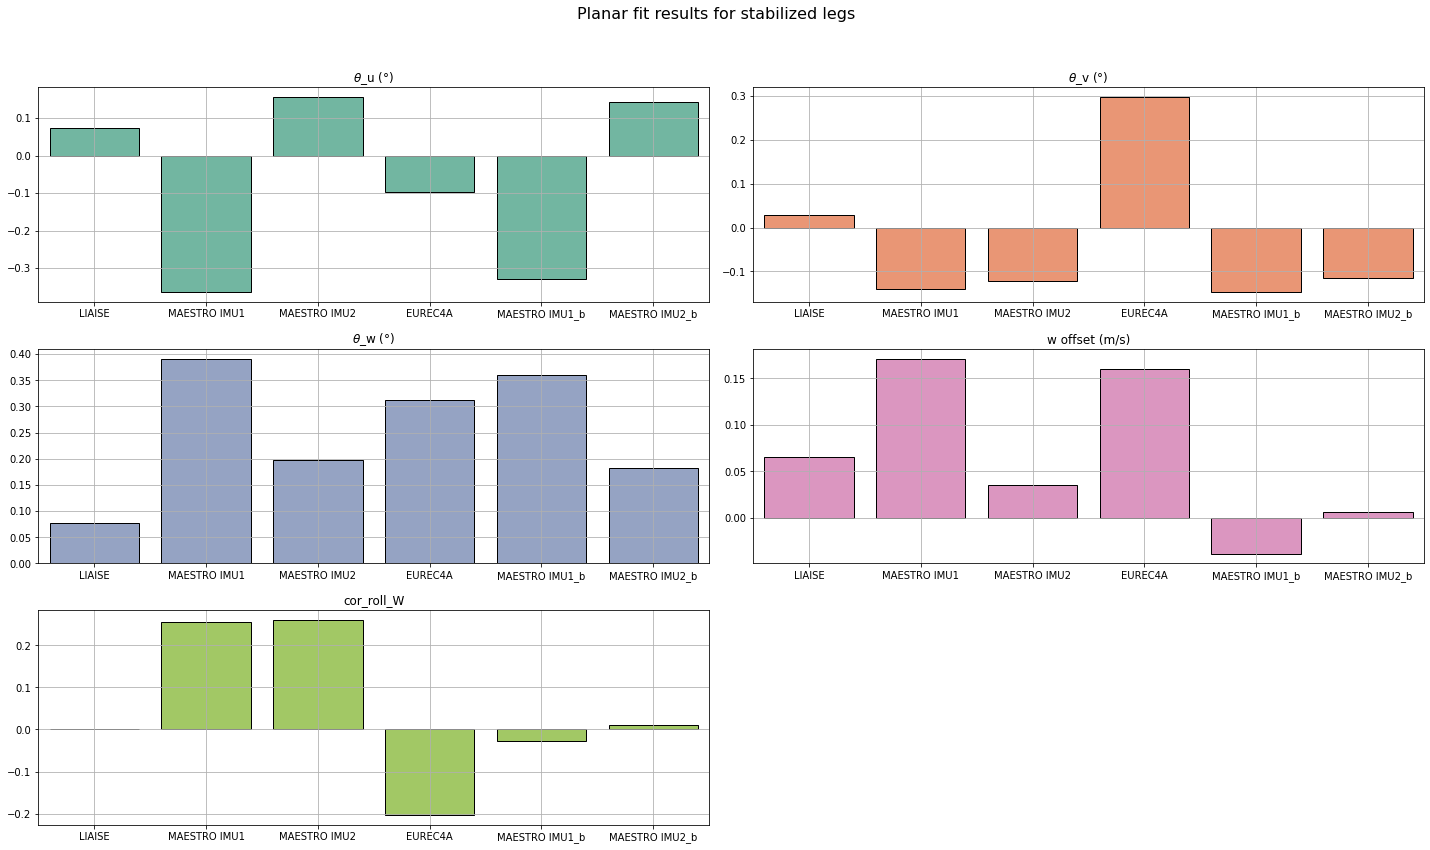

In [8]:
# Convert list of dicts to DataFrame
df = pd.DataFrame(results).set_index('campaign')


# Rename columns for prettier labels
label_map = {
    'theta_u': r'$\theta$_u (°)',
    'theta_v': r'$\theta$_v (°)',
    'theta_w': r'$\theta$_w (°)',
    'offset': 'w offset (m/s)',
    'corr roll w': 'Corr(Roll,W)'
}
df = df.rename(columns=label_map)

df.index = df.index +' '+ df['INS']
# Differentiate results from corrected data 
seen = set()
output_list = []

for item in df.index:
    if item in seen:
        output_list.append(item.strip() + '_b')
    else:
        seen.add(item)
        output_list.append(item.strip())
df.index = output_list
# Plotting
metrics = list(df.columns[1:])
n_metrics = len(metrics)
n_rows = (n_metrics + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(2 + len(df)*3, 4*n_rows))

colors = sns.color_palette("Set2", n_colors=n_metrics)  # More scalable color palette

for ax, metric, color in zip(axes.flat, metrics, colors):
    sns.barplot(x=df.index, y=metric, data=df, ax=ax, color=color, edgecolor='black')
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid()

# Hide unused axes if odd number of plots
for i in range(n_metrics, len(axes.flat)):
    axes.flat[i].set_visible(False)

plt.suptitle('Planar fit results for stabilized legs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Plots/Planar_fit_results_flexible.png', dpi=300)
plt.show()


# Control runs from LIAISE
## Altering LIAISE data with range of alpha_b, beta_b, and rotations and evaluating quality

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_summary = []

# Define alpha, beta, and rotations ranges
alpha_b_values = [-0.5, -0.2, -0.1, 0.0, 0.1, 0.2, 0.5]
beta_b_values = [-1.5, -1.0, -0.5, 0.5, 1.0, 1.5]
roll_b_values = [-0.5, -0.2, -0.1, 0.1, 0.2, 0.5]
yaw_b_values = [-0.5, -0.2, -0.1, 0.1, 0.2, 0.5]
pitch_b_values = [-0.5, -0.2, -0.1, 0.1, 0.2, 0.5]

print(' Runs for varying alpha_b ')
for alpha_b in alpha_b_values:
    _, summary = process_campaign_planar('LIAISE', 'IMU1', data_root='../../../Data', alpha_b=alpha_b, beta_b=0, roll_b=0, pitch_b=0, yaw_b=0)
    for entry in summary:
        entry.update({'alpha_b': alpha_b, 'beta_b': 0, 'roll_b': 0,'pitch_b': 0, 'yaw_b':0})
        results_summary.append(entry)

print(' Runs for varying beta_b ')
for beta_b in beta_b_values:
    _, summary = process_campaign_planar('LIAISE', 'IMU1', data_root='../../../Data', alpha_b=0, beta_b=beta_b, roll_b=0, pitch_b=0, yaw_b=0)
    for entry in summary:
        entry.update({'alpha_b': 0, 'beta_b': beta_b, 'roll_b': 0,'pitch_b': 0, 'yaw_b':0})
        results_summary.append(entry)

print(' Runs for varying roll_b ')
for roll_b in roll_b_values: 
    _, summary = process_campaign_planar('LIAISE', 'IMU1', data_root='../../../Data', alpha_b=0, beta_b=0, roll_b=roll_b, pitch_b=0, yaw_b=0)
    for entry in summary:
        entry.update({'alpha_b': 0, 'beta_b': 0, 'roll_b': roll_b,'pitch_b': 0, 'yaw_b':0})
        results_summary.append(entry)

print(' Runs for varying pitch_b ')
for pitch_b in pitch_b_values:
    _, summary = process_campaign_planar('LIAISE', 'IMU1', data_root='../../../Data', alpha_b=0, beta_b=0, roll_b=0, pitch_b=pitch_b, yaw_b=0)
    for entry in summary:
        entry.update({'alpha_b': 0, 'beta_b': 0, 'roll_b': 0,'pitch_b': pitch_b, 'yaw_b':0})
        results_summary.append(entry)

print(' Runs for varying yaw_b ')
for yaw_b in yaw_b_values:
    _, summary = process_campaign_planar('LIAISE', 'IMU1', data_root='../../../Data', alpha_b=0, beta_b=0, roll_b=0, pitch_b=0, yaw_b=yaw_b)
    for entry in summary:
        entry.update({'alpha_b': 0, 'beta_b': 0, 'roll_b': 0,'pitch_b': 0, 'yaw_b':yaw_b})
        results_summary.append(entry)

# Convert to DataFrame
df_summary = pd.DataFrame(results_summary)

 Run for varying alpha_b 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:59<00:00,  7.38s/it]


 Run for varying beta_b 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:56<00:00,  7.12s/it]


 Run for varying roll_b 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:17<00:00,  9.72s/it]


 Run for varying pitch_b 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:56<00:00,  7.07s/it]


 Run for varying yaw_b 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:58<00:00,  7.35s/it]


# Plotting the results

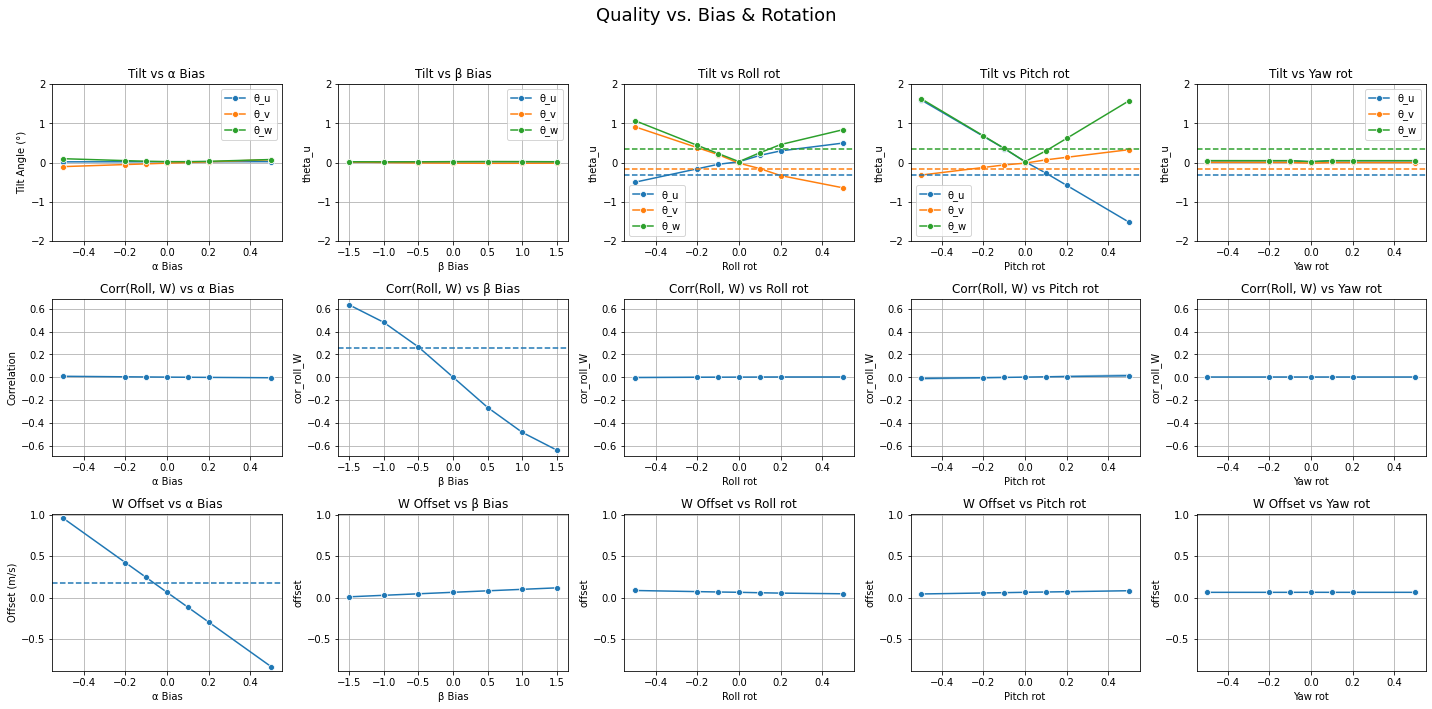

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convert to DataFrame
df_summary = pd.DataFrame(results_summary)
            
# Filter by parameter variations
df_alpha = df_summary[(df_summary['beta_b'] == 0) & (df_summary['roll_b'] == 0) & (df_summary['yaw_b'] == 0) & (df_summary['pitch_b'] == 0)]
df_beta  = df_summary[(df_summary['alpha_b'] == 0) & (df_summary['roll_b'] == 0) & (df_summary['yaw_b'] == 0) & (df_summary['pitch_b'] == 0)]
df_roll  = df_summary[(df_summary['alpha_b'] == 0) & (df_summary['beta_b'] == 0) & (df_summary['yaw_b'] == 0) & (df_summary['pitch_b'] == 0)]
df_pitch  = df_summary[(df_summary['alpha_b'] == 0) & (df_summary['beta_b'] == 0) & (df_summary['roll_b'] == 0)& (df_summary['yaw_b'] == 0)]
df_yaw  = df_summary[(df_summary['alpha_b'] == 0) & (df_summary['beta_b'] == 0) & (df_summary['roll_b'] == 0) & (df_summary['pitch_b'] == 0)]



        
# Split by region
df_alpha_in = df_alpha[df_alpha['region'] == 'Inside']
df_beta_in = df_beta[df_beta['region'] == 'Inside']
df_roll_in = df_roll[df_roll['region'] == 'Inside']
df_pitch_in = df_pitch[df_pitch['region'] == 'Inside']
df_yaw_in = df_yaw[df_yaw['region'] == 'Inside']

df_alpha_out = df_alpha[df_alpha['region'] == 'Outside']
df_beta_out = df_beta[df_beta['region'] == 'Outside']
df_roll_out = df_roll[df_roll['region'] == 'Outside']
df_pitch_out = df_pitch[df_pitch['region'] == 'Outside']
df_yaw_out = df_yaw[df_yaw['region'] == 'Outside']


# Compute y-limits for each row
theta_vals = pd.concat([
    df_alpha_in[['theta_u', 'theta_v', 'theta_w']],
    df_beta_in[['theta_u', 'theta_v', 'theta_w']],
    df_roll_in[['theta_u', 'theta_v', 'theta_w']],
    df_pitch_in[['theta_u', 'theta_v', 'theta_w']],
    df_yaw_in[['theta_u', 'theta_v', 'theta_w']],
]).values.flatten()
ylim_theta = [-2,2]

cor_vals = pd.concat([
    df_alpha_out['cor_roll_W'],
    df_beta_out['cor_roll_W'],
    df_roll_out['cor_roll_W'],
    df_pitch_out['cor_roll_W'],
    df_yaw_out['cor_roll_W']
]).values
ylim_cor = (cor_vals.min() - 0.05, cor_vals.max() + 0.05)

offset_vals = pd.concat([
    df_alpha_in['offset'],
    df_beta_in['offset'],
    df_roll_in['offset'],
    df_pitch_in['offset'],
    df_yaw_in['offset']
]).values
ylim_offset = (offset_vals.min() - 0.05, offset_vals.max() + 0.05)

# Create 3x3 subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle('Quality vs. Bias & Rotation', fontsize=18)

# --- Row 1: Tilt angles (theta_u/v/w) ---
sns.lineplot(ax=axes[0, 0], data=df_alpha_in, x='alpha_b', y='theta_u', marker='o', label='θ_u')
sns.lineplot(ax=axes[0, 0], data=df_alpha_in, x='alpha_b', y='theta_v', marker='o', label='θ_v')
sns.lineplot(ax=axes[0, 0], data=df_alpha_in, x='alpha_b', y='theta_w', marker='o', label='θ_w')
axes[0, 0].set(title='Tilt vs α Bias', xlabel='α Bias', ylabel='Tilt Angle (°)', ylim=ylim_theta)
#axes[0, 0].legend()
axes[0, 0].grid(True)

sns.lineplot(ax=axes[0, 1], data=df_beta_in, x='beta_b', y='theta_u', marker='o', label='θ_u')
sns.lineplot(ax=axes[0, 1], data=df_beta_in, x='beta_b', y='theta_v', marker='o', label='θ_v')
sns.lineplot(ax=axes[0, 1], data=df_beta_in, x='beta_b', y='theta_w', marker='o', label='θ_w')
axes[0, 1].set(title='Tilt vs β Bias', xlabel='β Bias', ylim=ylim_theta)
#axes[0, 1].legend()
axes[0, 1].grid(True)

sns.lineplot(ax=axes[0, 2], data=df_roll_in, x='roll_b', y='theta_u', marker='o', label='θ_u', errorbar=None)
sns.lineplot(ax=axes[0, 2], data=df_roll_in, x='roll_b', y='theta_v', marker='o', label='θ_v', errorbar=None)
sns.lineplot(ax=axes[0, 2], data=df_roll_in, x='roll_b', y='theta_w', marker='o', label='θ_w', errorbar=None)
axes[0, 2].axhline(y= su_imu1[0]['theta_u'], linestyle='--', label='MAESTRO1',color = 'C0')
axes[0, 2].axhline(y= su_imu1[0]['theta_v'], linestyle='--', label='MAESTRO1',color = 'C1')
axes[0, 2].axhline(y= su_imu1[0]['theta_w'], linestyle='--', label='MAESTRO1',color = 'C2')
axes[0, 2].set(title='Tilt vs Roll rot', xlabel='Roll rot', ylim=ylim_theta)
axes[0, 2].grid(True)

sns.lineplot(ax=axes[0, 3], data=df_pitch_in, x='pitch_b', y='theta_u', marker='o', label='θ_u', errorbar=None)
sns.lineplot(ax=axes[0, 3], data=df_pitch_in, x='pitch_b', y='theta_v', marker='o', label='θ_v', errorbar=None)
sns.lineplot(ax=axes[0, 3], data=df_pitch_in, x='pitch_b', y='theta_w', marker='o', label='θ_w', errorbar=None)
axes[0, 3].axhline(y= su_imu1[0]['theta_u'], linestyle='--', label='MAESTRO1',color = 'C0')
axes[0, 3].axhline(y= su_imu1[0]['theta_v'], linestyle='--', label='MAESTRO1',color = 'C1')
axes[0, 3].axhline(y= su_imu1[0]['theta_w'], linestyle='--', label='MAESTRO1',color = 'C2')
axes[0, 3].set(title='Tilt vs Pitch rot', xlabel='Pitch rot', ylim=ylim_theta)
axes[0, 3].grid(True)

sns.lineplot(ax=axes[0, 4], data=df_yaw_in, x='yaw_b', y='theta_u', marker='o', label='θ_u', errorbar=None)
sns.lineplot(ax=axes[0, 4], data=df_yaw_in, x='yaw_b', y='theta_v', marker='o', label='θ_v', errorbar=None)
sns.lineplot(ax=axes[0, 4], data=df_yaw_in, x='yaw_b', y='theta_w', marker='o', label='θ_w', errorbar=None)
axes[0, 4].axhline(y= su_imu1[0]['theta_u'], linestyle='--', label='MAESTRO1',color = 'C0')
axes[0, 4].axhline(y= su_imu1[0]['theta_v'], linestyle='--', label='MAESTRO1',color = 'C1')
axes[0, 4].axhline(y= su_imu1[0]['theta_w'], linestyle='--', label='MAESTRO1',color = 'C2')
axes[0, 4].set(title='Tilt vs Yaw rot', xlabel='Yaw rot', ylim=ylim_theta)
axes[0, 4].grid(True)
# --- Row 2: Correlation(Roll, W) ---
sns.lineplot(ax=axes[1, 0], data=df_alpha_out, x='alpha_b', y='cor_roll_W', marker='o')
axes[1, 0].set(title='Corr(Roll, W) vs α Bias', xlabel='α Bias', ylabel='Correlation', ylim=ylim_cor)
axes[1, 0].grid(True)

sns.lineplot(ax=axes[1, 1], data=df_beta_out, x='beta_b', y='cor_roll_W', marker='o')
axes[1, 1].axhline(y=su_imu1[1]['cor_roll_W'], linestyle='--', label='MAESTRO1',color = 'C0')
axes[1, 1].set(title='Corr(Roll, W) vs β Bias', xlabel='β Bias', ylim=ylim_cor)
axes[1, 1].grid(True)

sns.lineplot(ax=axes[1, 2], data=df_roll_out, x='roll_b', y='cor_roll_W', marker='o')
axes[1, 2].set(title='Corr(Roll, W) vs Roll rot', xlabel='Roll rot', ylim=ylim_cor)
axes[1, 2].grid(True)

sns.lineplot(ax=axes[1, 3], data=df_pitch_out, x='pitch_b', y='cor_roll_W', marker='o')
axes[1, 3].set(title='Corr(Roll, W) vs Pitch rot', xlabel='Pitch rot', ylim=ylim_cor)
axes[1, 3].grid(True)

sns.lineplot(ax=axes[1, 4], data=df_yaw_out, x='yaw_b', y='cor_roll_W', marker='o')
axes[1, 4].set(title='Corr(Roll, W) vs Yaw rot', xlabel='Yaw rot', ylim=ylim_cor)
axes[1, 4].grid(True)

# --- Row 3: Offset (w_offset) ---
sns.lineplot(ax=axes[2, 0], data=df_alpha_in, x='alpha_b', y='offset', marker='o')
axes[2, 0].axhline(y=su_imu1[0]['offset'], linestyle='--', label='MAESTRO1',color = 'C0')
axes[2, 0].set(title='W Offset vs α Bias', xlabel='α Bias', ylabel='Offset (m/s)', ylim=ylim_offset)
axes[2, 0].grid(True)

sns.lineplot(ax=axes[2, 1], data=df_beta_in, x='beta_b', y='offset', marker='o')
axes[2, 1].set(title='W Offset vs β Bias', xlabel='β Bias', ylim=ylim_offset)
axes[2, 1].grid(True)

sns.lineplot(ax=axes[2, 2], data=df_roll_in, x='roll_b', y='offset', marker='o', errorbar=None)
axes[2, 2].set(title='W Offset vs Roll rot', xlabel='Roll rot', ylim=ylim_offset)
axes[2, 2].grid(True)

sns.lineplot(ax=axes[2, 3], data=df_pitch_in, x='pitch_b', y='offset', marker='o', errorbar=None)
axes[2, 3].set(title='W Offset vs Pitch rot', xlabel='Pitch rot', ylim=ylim_offset)
axes[2, 3].grid(True)

sns.lineplot(ax=axes[2, 4], data=df_yaw_in, x='yaw_b', y='offset', marker='o', errorbar=None)
axes[2, 4].set(title='W Offset vs Yaw rot', xlabel='Yaw rot', ylim=ylim_offset)
axes[2, 4].grid(True)
# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Plots/Control_runs_LIAISE.png')
plt.show()


# Trying to apply rotation corrections (not working as is)

In [4]:

from scipy.spatial.transform import Rotation as R


# Function to apply roll perturbation to a single row



def load_campaign(campaign, INS, data_root='../../Data',alpha_b=0.0, beta_b=0.0):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    all_inside = []

    def residuals(params, u, v, w):
        a, b, c = params
        return w - (a * u + b * v + c)
    
    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    # Open all flight files, gather inside segments
    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        if flight_number is None:
            continue
            
        if flight_number < 200009 and campaign == 'EUREC4A':
            print(f'Skipping bad EUREC4A flight {flight_number}')
            continue
        yaml_path = os.path.join(segmentation_dir, fname)
        # Match raw data folder
        matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                               if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
        if not matching_raw_folder:
            print(f"No raw folder found for {campaign} {INS}")
            continue

        raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
        # Look for any .nc file containing the flight number
        flight_str = f'{flight_number:02d}'
        nc_candidates = [f for f in os.listdir(raw_folder)
                         if f.endswith('.nc') and flight_str in f]
        
        if not nc_candidates:
            print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
            continue
        
        nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
        #print(f"  - Loading NetCDF: {nc_candidates[0]}")

        yaml_data = read_yaml(yaml_path)
        df_raw = load_raw_data(nc_path)
        if 'SIDESLIP_RAD' in df_raw.columns:
            df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
        # Resampling to reduce computations (prevents memory shortage)
        df_raw = df_raw[['NORTH_SPEED','EAST_SPEED','VERTICAL_SPEED',
                         'ROLL','PITCH','HEADING',
                         'AOA_RAD','AOS_RAD','TAS',
                         'EASTWARD_WIND','NORTHWARD_WIND','VERTICAL_WIND']].resample('1s').mean()
        # Wind recomputation
        # Apply and overwrite original columns
        df_raw = df_raw.dropna()
        # Initialize segment mask
        mask_all_segments = pd.Series(False, index=df_raw.index)
        for seg in yaml_data['subsegments']:
            start = pd.to_datetime(seg['start'])
            end = pd.to_datetime(seg['end'])
            df_segment = df_raw[(df_raw.index >= start) & (df_raw.index <= end)]
            mask_all_segments |= (df_raw.index >= start) & (df_raw.index <= end)

        df_outside = df_raw[~mask_all_segments]
        df_inside = df_raw[mask_all_segments]
        all_inside.append(df_inside)
    

    df_inside = pd.concat(all_inside)
    df_inside['AOA_RAD'] += alpha_b
    df_inside['AOS_RAD'] += beta_b

    return df_inside

data_1 = load_campaign('MAESTRO', 'IMU1', data_root='../../../Data')
data_2 = load_campaign('MAESTRO', 'IMU2', data_root='../../../Data')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:02<00:00,  5.09s/it]


In [10]:
data_0 = load_campaign('LIAISE', 'IMU1', data_root='../../../Data')

def objective_function(d_angles, data):
    """
    d_angles: array([d_roll, d_yaw, d_pitch]) in radians
    """
    delta_phi,delta_head,delta_pit = d_angles
    def residuals(params, u, v, w):
        a, b, c = params
        return w - (a * u + b * v + c)
    def apply_roll_perturbation_inplace(row):
        """
        Applies a roll perturbation (delta_phi) to a given row representing orientation in ZYX Euler angles.
        
        Parameters:
        - row (dict-like): Should contain 'HEADING', 'PITCH', 'ROLL' in degrees.
        - delta_phi (float): Roll perturbation angle in degrees.
        
        Returns:
        - row (dict-like): Updated row with modified 'HEADING', 'PITCH', 'ROLL'.
        """
        # Original orientation
        r_orig = R.from_euler('ZYX', [row['HEADING'], row['PITCH'], row['ROLL']], degrees=True)
        
        # Perturbation rotation around ZYX (roll)
        r_delta = R.from_euler('ZYX', [delta_head, delta_pit, delta_phi], degrees=True)
        
        # Apply perturbation
        r_new = r_delta * r_orig
        
        # Convert back to Euler angles
        yaw_new, pitch_new, roll_new = r_new.as_euler('ZYX', degrees=True)
        
        # Update in place
        row['HEADING'] = np.float32(yaw_new)
        row['PITCH'] = np.float32(pitch_new)
        row['ROLL'] = np.float32(roll_new)
        
        return row
        
    # 1. Apply the rotation biases to the attitudes
    data_copy = data.copy()
    data_copy = data_copy.apply(apply_roll_perturbation_inplace, axis=1)

    U,V,W = wind_computation_bias(data_copy)

    
    data_copy['W']= W
    data_copy['U_WIND'] = U
    data_copy['V_WIND'] = V
    # Plane frame of reference
    data_copy[['U_L', 'V_T']] = data_copy.apply(wind_to_body_frame, axis=1)
    df_prep=data_copy[['U_L','V_T','W']].dropna()
    # Initial guess for the plane parameters (a, b, c)
    initial_params = [0, 0, 0]
    # Perform the least squares fit
    result, _ = leastsq(residuals, initial_params, args=(df_prep['U_L'].values, df_prep['V_T'].values, df_prep['W'].values))
    a, b, c = result
    normal = np.array([a, b, -1])  # normal vector to plane
    normal /= np.linalg.norm(normal)
    tilt_angle = np.arccos(np.abs(normal[2]))  # angle from vertical
    history.append({
        'd_angles': d_angles.copy(),
        'a': a,
        'b': b,
        'c': c,
        'objective': tilt_angle**2
    })

    pbar.update(1)
    
    return a**2+b**2

# Initial guess: no rotation
x0 = np.array([0.0, 0.0, 0.0])  # [d_roll, d_pitch, d_yaw] in radians
# Run optimization
history = []
max_iter = 100
pbar = tqdm(total=max_iter)
print("Optimizing attitude corrections")
result = minimize(
    objective_function,
    x0,
    args=(data_0),
    method='Nelder-Mead',  # Or 'BFGS' if gradients are well-behaved
    options={'maxiter': max_iter, 'disp': True}
)
pbar.close()

# Output optimal corrections
optimal_d_angles = result.x  # ∆roll, ∆pitch, ∆yaw in radians
print("Optimal attitude corrections (degrees):", optimal_d_angles)


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

Optimizing attitude corrections


127it [45:24, 21.46s/it]                                                                                                                                    

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 127
Optimal attitude corrections (degrees): [ 0.08054732 -0.10469757  0.12029395]


In [5]:
PF_tr = process_campaign_planar('MAESTRO', 'IMU1', data_root='../../../Data', alpha_b = 0.122,beta_b= 0.622, roll_b=0.44558862  ,yaw_b=-0.01878694,  pitch_b=-0.30647631)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:02<00:00,  7.61s/it]


In [6]:
PF_tr[1]

[{'campaign': 'MAESTRO',
  'INS': 'IMU1',
  'region': 'Inside',
  'theta_u': -2.5828123698186363,
  'theta_v': 0.9272982199649105,
  'theta_w': 2.743806573157408,
  'offset': -0.07675684609228149,
  'cor_roll_W': 0.23250284619870462,
  'cor_roll_norm': 0.017164551550626232},
 {'campaign': 'MAESTRO',
  'INS': 'IMU1',
  'region': 'Outside',
  'theta_u': -0.4548306669967985,
  'theta_v': 0.8620661417906621,
  'theta_w': 0.9746622674451499,
  'offset': 0.12663016162097357,
  'cor_roll_W': -0.03909373696716797,
  'cor_roll_norm': 0.005682180966057765},
 {'campaign': 'MAESTRO',
  'INS': 'IMU1',
  'region': 'All',
  'theta_u': -0.9936983130023259,
  'theta_v': 0.6924217671720957,
  'theta_w': 1.2110705999481517,
  'offset': 0.025493004421448535,
  'cor_roll_W': -0.0025503816080683253,
  'cor_roll_norm': 0.018628988902990085}]

In [8]:

def objective_function(d_angles, data):
    """
    d_angles: array([d_roll, d_yaw, d_pitch]) in radians
    """
    delta_phi,delta_head,delta_pit = d_angles
    def residuals(params, u, v, w):
        a, b, c = params
        return w - (a * u + b * v + c)
    def apply_roll_perturbation_inplace(row):
        """
        Applies a roll perturbation (delta_phi) to a given row representing orientation in ZYX Euler angles.
        
        Parameters:
        - row (dict-like): Should contain 'HEADING', 'PITCH', 'ROLL' in degrees.
        - delta_phi (float): Roll perturbation angle in degrees.
        
        Returns:
        - row (dict-like): Updated row with modified 'HEADING', 'PITCH', 'ROLL'.
        """
        # Original orientation
        r_orig = R.from_euler('ZYX', [row['HEADING'], row['PITCH'], row['ROLL']], degrees=True)
        
        # Perturbation rotation around ZYX (roll)
        r_delta = R.from_euler('ZYX', [delta_head, delta_pit, delta_phi], degrees=True)
        
        # Apply perturbation
        r_new = r_delta * r_orig
        
        # Convert back to Euler angles
        yaw_new, pitch_new, roll_new = r_new.as_euler('ZYX', degrees=True)
        
        # Update in place
        row['HEADING'] = np.float32(yaw_new)
        row['PITCH'] = np.float32(pitch_new)
        row['ROLL'] = np.float32(roll_new)
        
        return row
        
    # 1. Apply the rotation biases to the attitudes
    data_copy = data.copy()
    data_copy = data_copy.apply(apply_roll_perturbation_inplace, axis=1)

    U,V,W = wind_computation_bias(data_copy)

    
    data_copy['W']= W
    data_copy['U_WIND'] = U
    data_copy['V_WIND'] = V
    # Plane frame of reference
    data_copy[['U_L', 'V_T']] = data_copy.apply(wind_to_body_frame, axis=1)
    df_prep=data_copy[['U_L','V_T','W']].dropna()
    # Initial guess for the plane parameters (a, b, c)
    initial_params = [0, 0, 0]
    # Perform the least squares fit
    result, _ = leastsq(residuals, initial_params, args=(df_prep['U_L'].values, df_prep['V_T'].values, df_prep['W'].values))
    a, b, c = result
    normal = np.array([a, b, -1])  # normal vector to plane
    normal /= np.linalg.norm(normal)
    tilt_angle = np.arccos(np.abs(normal[2]))  # angle from vertical
    history.append({
        'd_angles': d_angles.copy(),
        'a': a,
        'b': b,
        'c': c,
        'objective': tilt_angle**2
    })

    pbar.update(1)
    
    return tilt_angle**2

# Initial guess: no rotation
x0 = np.array([0.0, 0.0, 0.0])  # [d_roll, d_pitch, d_yaw] in radians
# Run optimization
history = []
max_iter = 100
pbar = tqdm(total=max_iter)
print("Optimizing attitude corrections")
result = minimize(
    objective_function,
    x0,
    args=(data_1),
    method='Nelder-Mead',  # Or 'BFGS' if gradients are well-behaved
    options={'maxiter': max_iter, 'disp': True}
)
pbar.close()

# Output optimal corrections
optimal_d_angles = result.x  # ∆roll, ∆pitch, ∆yaw in radians
print("Optimal attitude corrections (degrees):", optimal_d_angles)


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

Optimizing attitude corrections


142it [1:34:28, 39.92s/it]                                                                                                                                  

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 142
Optimal attitude corrections (degrees): [ 0.05293415 -0.06873082  0.04411447]


In [7]:

def objective_function(d_angles, data):
    """
    d_angles: array([d_roll, d_yaw, d_pitch]) in radians
    """
    delta_phi,delta_head,delta_pit = d_angles
    def residuals(params, u, v, w):
        a, b, c = params
        return w - (a * u + b * v + c)
    def apply_roll_perturbation_inplace(row):
        """
        Applies a roll perturbation (delta_phi) to a given row representing orientation in ZYX Euler angles.
        
        Parameters:
        - row (dict-like): Should contain 'HEADING', 'PITCH', 'ROLL' in degrees.
        - delta_phi (float): Roll perturbation angle in degrees.
        
        Returns:
        - row (dict-like): Updated row with modified 'HEADING', 'PITCH', 'ROLL'.
        """
        # Original orientation
        r_orig = R.from_euler('ZYX', [row['HEADING'], row['PITCH'], row['ROLL']], degrees=True)
        
        # Perturbation rotation around ZYX (roll)
        r_delta = R.from_euler('ZYX', [delta_head, delta_pit, delta_phi], degrees=True)
        
        # Apply perturbation
        r_new = r_delta * r_orig
        
        # Convert back to Euler angles
        yaw_new, pitch_new, roll_new = r_new.as_euler('ZYX', degrees=True)
        
        # Update in place
        row['HEADING'] = np.float32(yaw_new)
        row['PITCH'] = np.float32(pitch_new)
        row['ROLL'] = np.float32(roll_new)
        
        return row
        
    # 1. Apply the rotation biases to the attitudes
    data_copy = data.copy()
    data_copy = data_copy.apply(apply_roll_perturbation_inplace, axis=1)

    U,V,W = wind_computation_bias(data_copy)

    
    data_copy['W']= W
    data_copy['U_WIND'] = U
    data_copy['V_WIND'] = V
    # Plane frame of reference
    data_copy[['U_L', 'V_T']] = data_copy.apply(wind_to_body_frame, axis=1)
    df_prep=data_copy[['U_L','V_T','W']].dropna()
    # Initial guess for the plane parameters (a, b, c)
    initial_params = [0, 0, 0]
    # Perform the least squares fit
    result, _ = leastsq(residuals, initial_params, args=(df_prep['U_L'].values, df_prep['V_T'].values, df_prep['W'].values))
    a, b, c = result
    # Save to history
    normal = np.array([a, b, -1])  # normal vector to plane
    normal /= np.linalg.norm(normal)
    tilt_angle = np.arccos(np.abs(normal[2]))  # angle from vertical
    history.append({
        'd_angles': d_angles.copy(),
        'a': a,
        'b': b,
        'c': c,
        'objective': tilt_angle**2
    })

    pbar.update(1)
    
    return tilt_angle**2

# Initial guess: no rotation
x0 = np.array([0.0, 0.0, 0.0])  # [d_roll, d_yaw, d_pitch] in radians
# Run optimization
history = []
max_iter = 100
pbar = tqdm(total=max_iter)
print("Optimizing attitude corrections")
result = minimize(
    objective_function,
    x0,
    args=(data_2),
    method='Nelder-Mead',  # Or 'BFGS' if gradients are well-behaved
    options={'maxiter': max_iter, 'disp': True}
)
pbar.close()

# Output optimal corrections
optimal_d_angles = result.x  # ∆roll, ∆pitch, ∆yaw in radians
print("Optimal attitude corrections (degrees):", optimal_d_angles)


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

Optimizing attitude corrections


124it [1:20:44, 39.07s/it]                                                                                                                                  

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 66
         Function evaluations: 124
Optimal attitude corrections (degrees): [ 0.11969918 -0.11106516 -0.03705563]


In [76]:
history_df = pd.DataFrame(history)
history_df['roll_deg'] = (history_df['d_angles'].apply(lambda x: x[0]))
history_df['yaw_deg'] = (history_df['d_angles'].apply(lambda x: x[1]))
history_df['pitch_deg'] = (history_df['d_angles'].apply(lambda x: x[2]))

# Tilt angle of the wind plane (angle from vertical)
normal_vec = history_df[['a', 'b']].to_numpy()
tilt_angles = np.arctan2(np.linalg.norm(normal_vec, axis=1), 1.0)  # tilt = atan(sqrt(a² + b²))
history_df['tilt_deg'] = np.degrees(tilt_angles)

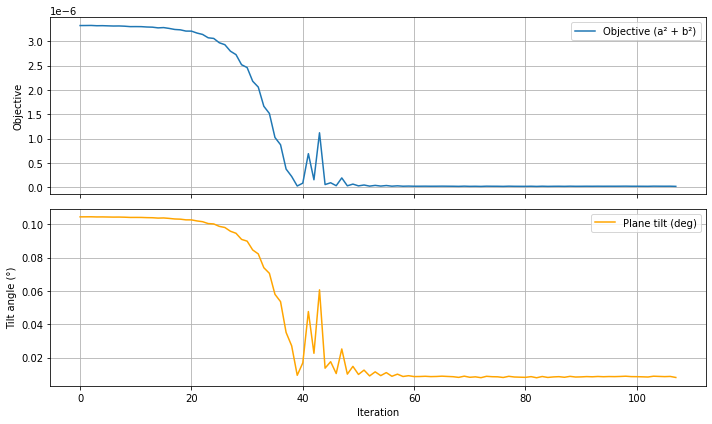

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(history_df['objective'], label='Objective (a² + b²)')
ax[0].set_ylabel("Objective")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history_df['tilt_deg'], label='Plane tilt (deg)', color='orange')
ax[1].set_ylabel("Tilt angle (°)")
ax[1].set_xlabel("Iteration")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


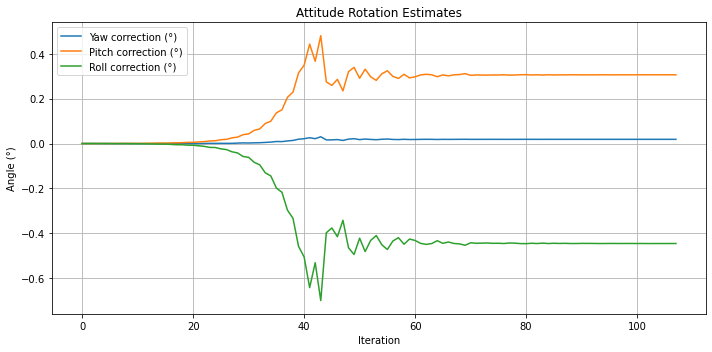

In [96]:
plt.figure(figsize=(10, 5))
plt.plot(history_df['yaw_deg'], label='Yaw correction (°)')
plt.plot(history_df['pitch_deg'], label='Pitch correction (°)')
plt.plot(history_df['roll_deg'], label='Roll correction (°)')
plt.xlabel("Iteration")
plt.ylabel("Angle (°)")
plt.legend()
plt.grid(True)
plt.title("Attitude Rotation Estimates")
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np



df_prep = 
# Final wind points
x = df_prep['U_L'].values
y = df_prep['V_T'].values
z = df_prep['W'].values

# Fitted plane parameters from final optimization
a = history_df.iloc[-1]['a']
b = history_df.iloc[-1]['b']
c = history_df.iloc[-1]['c']

# Generate a grid to plot the plane
x_range = np.linspace(np.min(x), np.max(x), 20)
y_range = np.linspace(np.min(y), np.max(y), 20)
X, Y = np.meshgrid(x_range, y_range)
Z = a * X + b * Y + c

# Create the scatter and surface plot
fig = go.Figure()

# Wind vector points
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.5),
    name='Wind Vectors'
))

# Fitted plane surface
fig.add_trace(go.Surface(
    x=X, y=Y, z=Z,
    colorscale='Reds',
    opacity=0.6,
    name='Fitted Plane',
    showscale=False
))

# Axis and layout
fig.update_layout(
    scene=dict(
        xaxis_title='U_L',
        yaxis_title='V_T',
        zaxis_title='W',
    ),
    title='Wind Plane Fit in Body Frame',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [4]:
PF_imu1_ori = process_campaign_planar('MAESTRO', 'IMU1', data_root='../../../Data',alpha_b = 0.121, beta_b = 0.622)
# Prepare x and y values
flights = [entry['flight'] for entry in PF_imu2_ori]

# Configurations
greek_labels = [ r'$\gamma$',r'$\alpha$', r'$\beta$','w offset']
colors = {'PF_inside': 'tab:red', 'PF_outside': 'tab:green', 'PF_all': 'tab:blue'}
markers = {'PF_inside': 'o', 'PF_outside': 's', 'PF_all': 'D'}
datasets = ['PF_inside', 'PF_outside', 'PF_all']

# Plot each component separately
for i, greek in enumerate(greek_labels):
    plt.figure(figsize=(6, 3))
    for ds in datasets:#datasets:
        y = [entry[ds][i] for entry in PF_imu1_ori]
        plt.scatter(flights, y, 
                 marker=markers[ds], 
                 linestyle='-', 
                 label=f"{ds.split('_')[1].capitalize()}",
                 color=colors[ds],
                   s= 50)
        # Compute and plot average line
        avg_value = np.mean(y)
        plt.axhline(y=avg_value, color=colors[ds], linestyle='--', linewidth=1,
                    label=f"{ds.split('_')[1].capitalize()} Avg {avg_value:.3f}")
    
    plt.xlabel('Flight')
    plt.ylabel(f'MAESTRO biased IMU1 PF {greek}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:47<00:00,  6.98s/it]


MAESTRO IMU1, Inside : All flights PF :-0.470, -0.118, -0.484, offset = -0.059 m/s
MAESTRO IMU1, Outside : All flights PF :-0.053, -0.020, -0.057, offset = 0.083 m/s
MAESTRO IMU1, All : All flights PF :-0.190, -0.022, -0.191, offset = -0.001 m/s


NameError: name 'PF_imu2_ori' is not defined

In [4]:

# Assuming df_stats is already defined
df_stats = df_summary_imu1_ori.dropna()
df_stats = df_stats[(df_stats['heading_diff'] < 200) & (df_stats['heading_diff'] > 160)]
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
bins = np.arange(-5,5,0.5)
# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')


# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(f'Histogram of {diff_par}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_MAESTRO_imu1_ori.png')
plt.show()


# Assuming df_stats is already defined
df_stats = df_summary_imu2_ori.dropna()
df_stats = df_stats[(df_stats['heading_diff'] < 200) & (df_stats['heading_diff'] > 160)]
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
bins = np.arange(-5,5,0.5)
# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')


# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(f'Histogram of {diff_par}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_MAESTRO_imu2_ori.png')
plt.show()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

/tmp/ipykernel_247804/1203924042.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_247804/1203924042.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


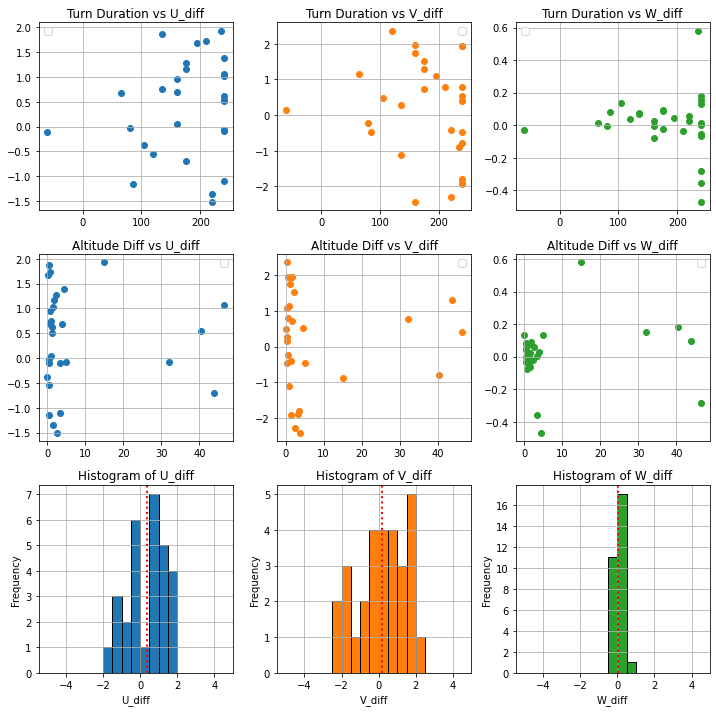

/tmp/ipykernel_247804/1203924042.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_247804/1203924042.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


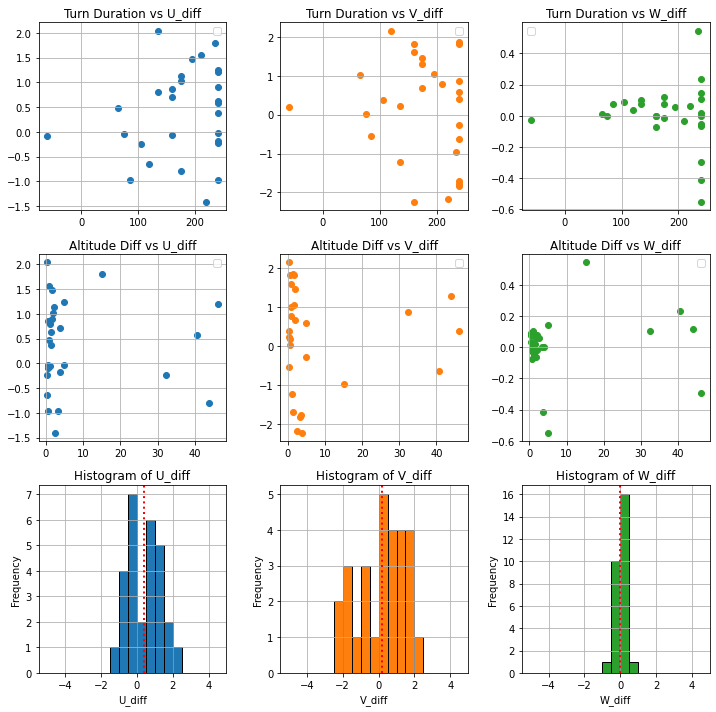

In [25]:

# Assuming df_stats is already defined
df_stats = df_summary_imu1_bias.dropna()
df_stats = df_stats[(df_stats['heading_diff'] < 200) & (df_stats['heading_diff'] > 160)]
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
bins = np.arange(-5,5,0.5)
# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')


# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(f'Histogram of {diff_par}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_MAESTRO_imu1_bias.png')
plt.show()


# Assuming df_stats is already defined
df_stats = df_summary_imu2_bias.dropna()
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])
df_stats = df_stats[(df_stats['heading_diff'] < 200) & (df_stats['heading_diff'] > 160)]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
bins = np.arange(-5,5,0.5)
# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')


# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(f'Histogram of {diff_par}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_MAESTRO_imu2_bias.png')
plt.show()


/tmp/ipykernel_247804/3753029870.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_247804/3753029870.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


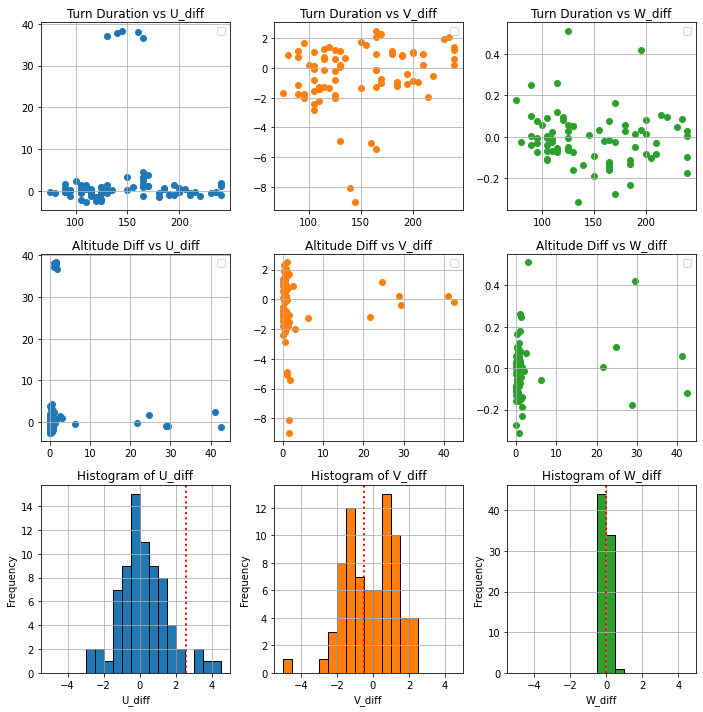

In [27]:

# Assuming df_stats is already defined
df_stats = df_summary_liaise.dropna()
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])
df_stats = df_stats[(df_stats['heading_diff'] < 200) & (df_stats['heading_diff'] > 160)]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
bins = np.arange(-5,5,0.5)
# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')


# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(f'Histogram of {diff_par}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_LIAISE.png')
plt.show()


/tmp/ipykernel_247804/2598679828.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_247804/2598679828.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


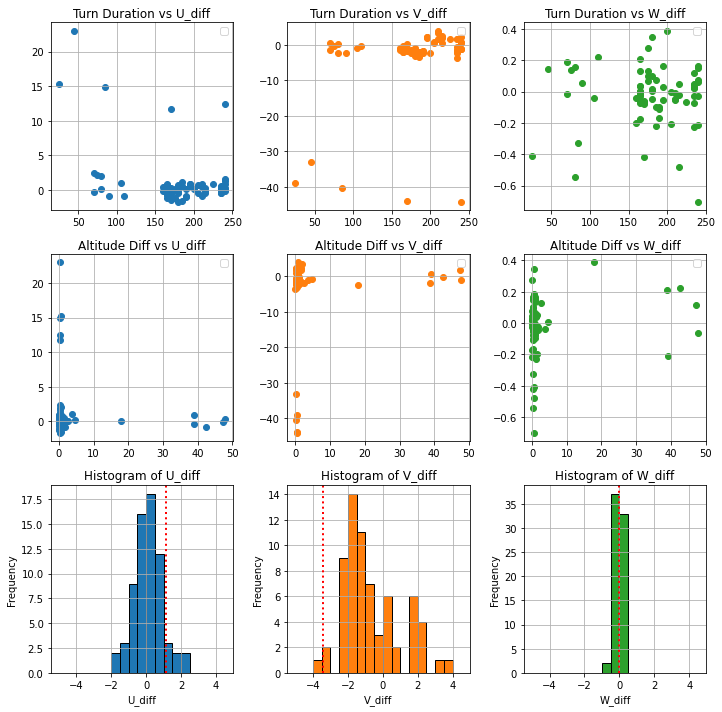

In [29]:

# Assuming df_stats is already defined
df_stats = df_summary_eureca.dropna()
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])
df_stats = df_stats[(df_stats['heading_diff'] < 200) & (df_stats['heading_diff'] > 160)]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
bins = np.arange(-5,5,0.5)
# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par], c=f'C{i}')
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')


# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_title(f'Histogram of {diff_par}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_EUREC4A.png')
plt.show()


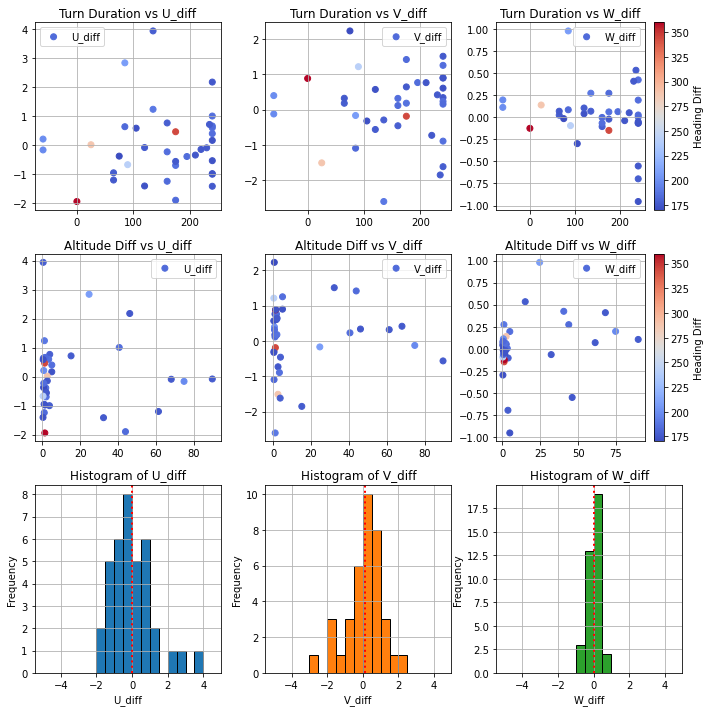

In [11]:

# Assuming df_stats is already defined
df_stats = df_summary_imu2_ori.dropna()
df_stats['U_diff'] = (df_stats['U_wind_before'] - df_stats['U_wind_after'])
df_stats['V_diff'] = (df_stats['V_wind_before'] - df_stats['V_wind_after'])
df_stats['W_diff'] = (df_stats['W_wind_before'] - df_stats['W_wind_after'])

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Plot for turn_duration_sec vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[0, i]  # First row (turn_duration_sec)
    scatter = ax.scatter(df_stats['turn_duration_sec'], df_stats[diff_par],# vmin=160, vmax=200,
                         c=df_stats['heading_diff'], cmap='coolwarm', label=diff_par)
    ax.grid()
    ax.legend()
    ax.set_title(f'Turn Duration vs {diff_par}')
    if i ==2:
        fig.colorbar(scatter, ax=ax, label='Heading Diff')  # Add colorbar

# Plot for altitude_diff vs U_diff, V_diff, W_diff with color based on heading_diff
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[1, i]  # Second row (altitude_diff)
    scatter = ax.scatter(df_stats['altitude_diff'], df_stats[diff_par],# vmin=160, vmax=200,
                         c=df_stats['heading_diff'], cmap='coolwarm', label=diff_par)
    ax.grid()
    ax.legend()
    ax.set_title(f'Altitude Diff vs {diff_par}')
    if i ==2:
        fig.colorbar(scatter, ax=ax, label='Heading Diff')  # Add colorbar

# Plot histograms for U_diff, V_diff, W_diff in the third row
for i, diff_par in enumerate(['U_diff', 'V_diff', 'W_diff']):
    ax = axes[2, i]  # Third row (histograms)
    ax.hist(df_stats[diff_par], bins=bins, color=f'C{i}', edgecolor='black')
    ax.set_title(f'Histogram of {diff_par}')
    mean_value = df_stats[diff_par].mean()
    ax.axvline(mean_value, color='red', linestyle='dotted', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.set_xlabel(diff_par)
    ax.set_ylabel('Frequency')
    ax.grid()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('../../../../MAESTRO/Report/Turns_MAESTRO_imu2.png')
plt.show()


In [2]:
def process_campaign_all(campaign, INS, data_root='../../Data'):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []
    stats = []
    #print(f"Looking in: {segmentation_dir}")
    #print("Files found:", os.listdir(segmentation_dir))

    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        #print(f'Flight {flight_number}')
        if flight_number is None:
            continue

        try:
            #print(f'Processing flight {flight_number}...')
            yaml_path = os.path.join(segmentation_dir, fname)

            # Match raw data folder
            matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                                   if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
            if not matching_raw_folder:
                print(f"No raw folder found for {campaign} {INS}")
                continue

            raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
            # Look for any .nc file containing the flight number
            flight_str = f'{flight_number:02d}'
            nc_candidates = [f for f in os.listdir(raw_folder)
                             if f.endswith('.nc') and flight_str in f]
            
            if not nc_candidates:
                print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
                continue
            
            nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
            #print(f"  - Loading NetCDF: {nc_candidates[0]}")

            yaml_data = read_yaml(yaml_path)
            df_raw = load_raw_data(nc_path)
            if 'SIDESLIP_RAD' in df_raw.columns:
                df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
            U,V,W = wind_computation_bias(df_raw, aoa_bias = -0.01, aos_bias = -0.545)
            df_raw['VERTICAL_WIND']= W
            stat_seg = []
            # Segment mask
            mask_all_segments = pd.Series(False, index=df_raw.index)
            for seg in yaml_data['subsegments']:
                start = pd.to_datetime(seg['start'])
                end = pd.to_datetime(seg['end'])
                df_segment = df_raw[(df_raw.index >= start) & (df_raw.index <= end)]
                #stat_seg.append(compute_stats(df_segment))
                mask_all_segments |= (df_raw.index >= start) & (df_raw.index <= end)

            results.append({
                'flight': flight_number,
                'Stats': df_raw[mask_all_segments],
            })
        except Exception as e:
            print(f"❌ Error in flight {flight_number}: {e}")
    
    return results

# Evaluate bias in attack and sideslip to get average  W to be 0, at flight scale

In [9]:
def objective(params, df):
    aoa_bias, aos_bias = params
    U,V,W = wind_computation_bias(df, aoa_bias*1e5, aos_bias*1e5)
    # Calculate the mean squared error between W and 0 (i.e., make W as close to zero as possible)
    mse = np.mean(W**2)
    return mse

def process_campaign_bias(campaign, INS, data_root='../../Data'):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []

    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        if flight_number is None:
            continue

        try:
            yaml_path = os.path.join(segmentation_dir, fname)

            # Match raw data folder
            matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                                   if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
            if not matching_raw_folder:
                print(f"No raw folder found for {campaign} {INS}")
                continue

            raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
            # Look for any .nc file containing the flight number
            flight_str = f'{flight_number:02d}'
            nc_candidates = [f for f in os.listdir(raw_folder)
                             if f.endswith('.nc') and flight_str in f]
            
            if not nc_candidates:
                print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
                continue
            
            nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
            # print(f"  - Loading NetCDF: {nc_candidates[0]}")

            yaml_data = read_yaml(yaml_path)
            df_raw = load_raw_data(nc_path)
            if 'SIDESLIP_RAD' in df_raw.columns:
                df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
            
            #U,V,W = wind_computation_bias(df_raw, aoa_bias = -0.01, aos_bias = -0.545)
            stat_seg = []
            # Segment mask
            

            df_prep = df_raw
            initial_guess = [0, 0]  # Start with zero bias and a TAS correction of 1

            # Define bounds if needed (e.g., aoa_bias and aos_bias between -10 and 10 degrees, tas_cor between 0.8 and 1.2)
            bounds = [(-1, 1), (-1, 1)]
            #  bounds = [(-1, 1), (-1, 1), (0.8, 1.2)]
        
            # Run the optimization
            #result = least_squares(W_wind_computation_complete, initial_guess, args=(df_prep,), bounds=bounds)
        
            result = minimize(objective, initial_guess, args=(df_prep,), bounds=bounds, method='L-BFGS-B')
            aoa_bias, aos_bias = result.x
            results.append({
                'flight': flight_number,
                'aoa_bias': 1e5*aoa_bias ,
                'aos_bias': 1e5*aos_bias ,
            })
        except Exception as e:
            print(f"❌ Error in flight {flight_number}: {e}")

    return results

In [10]:
results = process_campaign_bias('MAESTRO', 'IMU2', data_root='../../../Data')
df_biases_imu2 = pd.DataFrame(results)
results = process_campaign_bias('MAESTRO', 'IMU1', data_root='../../../Data')
df_biases_imu1 = pd.DataFrame(results)
results = process_campaign_bias('EUREC4A', '', data_root='../../../Data')
df_biases_eureca = pd.DataFrame(results)
results = process_campaign_bias('LIAISE', '', data_root='../../../Data')
df_biases_liaise = pd.DataFrame(results)

Looking in: ../../../Data/Segmentation_default/MAESTRO/IMU2
Files found: ['flight_240033_subsegments.yaml', 'flight_240031_subsegments.yaml', 'flight_240025_subsegments.yaml', 'flight_240038_subsegments.yaml', 'flight_240036_subsegments.yaml', 'flight_240037_subsegments.yaml', 'flight_240029_subsegments.yaml', 'flight_240042_subsegments.yaml', 'flight_240024_subsegments.yaml', 'flight_240023_subsegments.yaml', 'flight_240026_subsegments.yaml', 'flight_240032_subsegments.yaml', 'flight_240027_subsegments.yaml', 'flight_240041_subsegments.yaml', 'flight_240034_subsegments.yaml', 'flight_240040_subsegments.yaml', 'flight_240044_subsegments.yaml', 'flight_240045_subsegments.yaml', 'flight_240035_subsegments.yaml', 'flight_240043_subsegments.yaml', 'flight_240030_subsegments.yaml', 'flight_240039_subsegments.yaml', 'flight_240046_subsegments.yaml', 'flight_240028_subsegments.yaml']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:27<00:00, 11.14s/it]


Looking in: ../../../Data/Segmentation_default/MAESTRO/IMU1
Files found: ['flight_240033_subsegments.yaml', 'flight_240031_subsegments.yaml', 'flight_240025_subsegments.yaml', 'flight_240038_subsegments.yaml', 'flight_240036_subsegments.yaml', 'flight_240037_subsegments.yaml', 'flight_240029_subsegments.yaml', 'flight_240042_subsegments.yaml', 'flight_240024_subsegments.yaml', 'flight_240023_subsegments.yaml', 'flight_240026_subsegments.yaml', 'flight_240032_subsegments.yaml', 'flight_240027_subsegments.yaml', 'flight_240041_subsegments.yaml', 'flight_240034_subsegments.yaml', 'flight_240040_subsegments.yaml', 'flight_240044_subsegments.yaml', 'flight_240045_subsegments.yaml', 'flight_240035_subsegments.yaml', 'flight_240043_subsegments.yaml', 'flight_240030_subsegments.yaml', 'flight_240039_subsegments.yaml', 'flight_240046_subsegments.yaml', 'flight_240028_subsegments.yaml']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:24<00:00, 11.02s/it]


Looking in: ../../../Data/Segmentation_default/EUREC4A/
Files found: ['flight_200019_subsegments.yaml', 'flight_200015_subsegments.yaml', 'flight_200007_subsegments.yaml', 'flight_200002_subsegments.yaml', 'flight_200018_subsegments.yaml', 'flight_200012_subsegments.yaml', 'flight_200017_subsegments.yaml', 'flight_200005_subsegments.yaml', 'flight_200011_subsegments.yaml', 'flight_200013_subsegments.yaml', 'flight_200014_subsegments.yaml', 'flight_200010_subsegments.yaml', 'flight_200009_subsegments.yaml', 'flight_200003_subsegments.yaml', 'flight_200006_subsegments.yaml', 'flight_200016_subsegments.yaml', 'flight_200008_subsegments.yaml', 'flight_200004_subsegments.yaml']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:47<00:00,  5.97s/it]


Looking in: ../../../Data/Segmentation_default/LIAISE/
Files found: ['flight_210042_subsegments.yaml', 'flight_210046_subsegments.yaml', 'flight_210041_subsegments.yaml', 'flight_210045_subsegments.yaml', 'flight_210040_subsegments.yaml', 'flight_210044_subsegments.yaml', 'flight_210047_subsegments.yaml', 'flight_210043_subsegments.yaml']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:30<00:00, 11.33s/it]


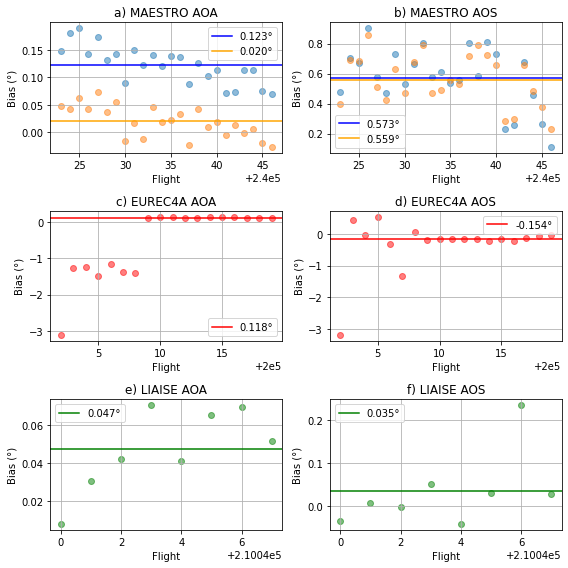

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=False)

# MAESTRO aoa
axs[0, 0].scatter(df_biases_imu1['flight'], -df_biases_imu1['aoa_bias'], alpha=0.5)
axs[0, 0].scatter(df_biases_imu1['flight'], -df_biases_imu2['aoa_bias'], alpha=0.5)
mean=-df_biases_imu1['aoa_bias'].mean()
axs[0, 0].axhline(y=mean , label=f'{mean:.03f}°', color='blue')
mean=-df_biases_imu2['aoa_bias'].mean()
axs[0, 0].axhline(y=mean , label=f'{mean:.03f}°', color='orange')
axs[0, 0].set_title('a) MAESTRO AOA')
axs[0, 0].grid()
axs[0, 0].legend()

# MAESTRO aos
axs[0, 1].scatter(df_biases_imu1['flight'], -df_biases_imu1['aos_bias'], alpha=0.5)
axs[0, 1].scatter(df_biases_imu1['flight'], -df_biases_imu2['aos_bias'], alpha=0.5)
mean=-df_biases_imu1['aos_bias'].mean()
axs[0, 1].axhline(y=mean , label=f'{mean:.03f}°', color='blue')
mean=-df_biases_imu2['aos_bias'].mean()
axs[0, 1].axhline(y=mean , label=f'{mean:.03f}°', color='orange')
axs[0, 1].set_title('b) MAESTRO AOS')
axs[0, 1].grid()
axs[0, 1].legend()

# EUREC4A aoa
axs[1, 0].scatter(df_biases_eureca['flight'], -df_biases_eureca['aoa_bias'], alpha=0.5, color='red')
mean=-df_biases_eureca[df_stats_eureca['flight']>200008]['aoa_bias'].mean()
axs[1, 0].axhline(y=mean , label=f'{mean:.03f}°', color='red')
axs[1, 0].set_title('c) EUREC4A AOA')
axs[1, 0].grid()
axs[1, 0].legend()

# EUREC4A aos
axs[1, 1].scatter(df_biases_eureca['flight'], -df_biases_eureca['aos_bias'], alpha=0.5, color='red')
mean=-df_biases_eureca[df_stats_eureca['flight']>200008]['aos_bias'].mean()
axs[1, 1].axhline(y=mean , label=f'{mean:.03f}°', color='red')
axs[1, 1].set_title('d) EUREC4A AOS')
axs[1, 1].grid()
axs[1, 1].legend()

# LIAISE aoa
axs[2, 0].scatter(df_biases_liaise['flight'], -df_biases_liaise['aoa_bias'], alpha=0.5, color='green')
mean=-df_biases_liaise['aoa_bias'].mean()
axs[2, 0].axhline(y=mean , label=f'{mean:.03f}°', color='green')
axs[2, 0].set_title('e) LIAISE AOA')
axs[2, 0].grid()
axs[2, 0].legend()

# LIAISE aos
axs[2, 1].scatter(df_biases_liaise['flight'], -df_biases_liaise['aos_bias'], alpha=0.5, color='green')
mean=-df_biases_liaise['aos_bias'].mean()
axs[2, 1].axhline(y=mean , label=f'{mean:.03f}°', color='green')
axs[2, 1].set_title('f) LIAISE AOS')
axs[2, 1].grid()
axs[2, 1].legend()

# General layout tweaks
for ax in axs.flat:
    ax.set_xlabel('Flight')
    ax.set_ylabel('Bias (°)')

plt.tight_layout()
plt.savefig('../../../Plots/bias_estimation.png')

In [2]:
def objective(params, df):
    A,B,C,D = params
    W = W_wind_computation_calib(df, A,B,C,D)
    # Calculate the mean squared error between W and 0 (i.e., make W as close to zero as possible)
    mse = np.mean(W**2)
    return mse

def process_campaign_calib(campaign, INS, data_root='../../Data'):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []
    print(f"Looking in: {segmentation_dir}")
    print("Files found:", os.listdir(segmentation_dir))
    tab_all =[]
    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        if flight_number is None:
            continue
        if campaign=='EUREC4A' and flight_number<200008:  # exclude bad eurec4A flights
            continue
        yaml_path = os.path.join(segmentation_dir, fname)

        # Match raw data folder
        matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                               if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
        if not matching_raw_folder:
            print(f"No raw folder found for {campaign} {INS}")
            continue

        raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
        # Look for any .nc file containing the flight number
        flight_str = f'{flight_number:02d}'
        nc_candidates = [f for f in os.listdir(raw_folder)
                         if f.endswith('.nc') and flight_str in f]
        
        if not nc_candidates:
            print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
            continue
        
        nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
        # print(f"  - Loading NetCDF: {nc_candidates[0]}")

        yaml_data = read_yaml(yaml_path)
        df_raw = load_raw_data(nc_path)
        if 'DPIRAD' in df_raw.columns:
            df_raw['DPJ_RAD'] = df_raw['DPJRAD']
            df_raw['DPI_RAD'] = df_raw['DPIRAD']
        
        stat_seg = []
        # Segment mask
        mask_all_segments = pd.Series(False, index=df_raw.index)
        for seg in yaml_data['subsegments']:
            start = pd.to_datetime(seg['start'])
            end = pd.to_datetime(seg['end'])
            mask_all_segments |= (df_raw.index >= start) & (df_raw.index <= end)

        tab_all.append(df_raw[mask_all_segments])
    df_prep = pd.concat(tab_all)
    initial_guess = [1, 0, 1, 0] 
    bounds = [(0, 2), (-2, 2), (0, 2), (-2, 2)]

    result = minimize(objective, initial_guess, args=(df_prep,), bounds=bounds,method='Powell', options={'disp': False})
    A,B,C,D = result.x
    results.append({
        'flight': flight_number,
        'A': A ,
        'B': B ,
        'C': C ,
        'D': D ,
    })


    return results

In [3]:
results = process_campaign_calib('MAESTRO', 'IMU2', data_root='../../Data')
df_calib_imu2 = pd.DataFrame(results)
results = process_campaign_calib('MAESTRO', 'IMU1', data_root='../../Data')
df_calib_imu1 = pd.DataFrame(results)
results = process_campaign_calib('EUREC4A', '', data_root='../../Data')
df_calib_eureca = pd.DataFrame(results)
results = process_campaign_calib('LIAISE', '', data_root='../../Data')

df_calib_liaise = pd.DataFrame(results)

Looking in: ../../Data/Segmentation_default/MAESTRO/IMU2
Files found: ['flight_240033_subsegments.yaml', 'flight_240031_subsegments.yaml', 'flight_240025_subsegments.yaml', 'flight_240038_subsegments.yaml', 'flight_240036_subsegments.yaml', 'flight_240037_subsegments.yaml', 'flight_240029_subsegments.yaml', 'flight_240042_subsegments.yaml', 'flight_240024_subsegments.yaml', 'flight_240023_subsegments.yaml', 'flight_240026_subsegments.yaml', 'flight_240032_subsegments.yaml', 'flight_240027_subsegments.yaml', 'flight_240041_subsegments.yaml', 'flight_240034_subsegments.yaml', 'flight_240040_subsegments.yaml', 'flight_240044_subsegments.yaml', 'flight_240045_subsegments.yaml', 'flight_240035_subsegments.yaml', 'flight_240043_subsegments.yaml', 'flight_240030_subsegments.yaml', 'flight_240039_subsegments.yaml', 'flight_240046_subsegments.yaml', 'flight_240028_subsegments.yaml']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.80s/it]


Looking in: ../../Data/Segmentation_default/MAESTRO/IMU1
Files found: ['flight_240033_subsegments.yaml', 'flight_240031_subsegments.yaml', 'flight_240025_subsegments.yaml', 'flight_240038_subsegments.yaml', 'flight_240036_subsegments.yaml', 'flight_240037_subsegments.yaml', 'flight_240029_subsegments.yaml', 'flight_240042_subsegments.yaml', 'flight_240024_subsegments.yaml', 'flight_240023_subsegments.yaml', 'flight_240026_subsegments.yaml', 'flight_240032_subsegments.yaml', 'flight_240027_subsegments.yaml', 'flight_240041_subsegments.yaml', 'flight_240034_subsegments.yaml', 'flight_240040_subsegments.yaml', 'flight_240044_subsegments.yaml', 'flight_240045_subsegments.yaml', 'flight_240035_subsegments.yaml', 'flight_240043_subsegments.yaml', 'flight_240030_subsegments.yaml', 'flight_240039_subsegments.yaml', 'flight_240046_subsegments.yaml', 'flight_240028_subsegments.yaml']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.83s/it]


Looking in: ../../Data/Segmentation_default/EUREC4A/
Files found: ['flight_200019_subsegments.yaml', 'flight_200015_subsegments.yaml', 'flight_200007_subsegments.yaml', 'flight_200002_subsegments.yaml', 'flight_200018_subsegments.yaml', 'flight_200012_subsegments.yaml', 'flight_200017_subsegments.yaml', 'flight_200005_subsegments.yaml', 'flight_200011_subsegments.yaml', 'flight_200013_subsegments.yaml', 'flight_200014_subsegments.yaml', 'flight_200010_subsegments.yaml', 'flight_200009_subsegments.yaml', 'flight_200003_subsegments.yaml', 'flight_200006_subsegments.yaml', 'flight_200016_subsegments.yaml', 'flight_200008_subsegments.yaml', 'flight_200004_subsegments.yaml']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.19it/s]


Looking in: ../../Data/Segmentation_default/LIAISE/
Files found: ['flight_210042_subsegments.yaml', 'flight_210046_subsegments.yaml', 'flight_210041_subsegments.yaml', 'flight_210045_subsegments.yaml', 'flight_210040_subsegments.yaml', 'flight_210044_subsegments.yaml', 'flight_210047_subsegments.yaml', 'flight_210043_subsegments.yaml']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.49s/it]


In [6]:
print(180/np.pi*df_calib_imu1[['A','B','C','D']])
print(180/np.pi*df_calib_imu2[['A','B','C','D']])
print(180/np.pi*df_calib_liaise[['A','B','C','D']])
print(180/np.pi*df_calib_eureca[['A','B','C','D']])


            A          B          C         D
0  114.060031  82.337524  38.415557  1.700379
          A          B          C         D
0  114.2166  82.112851  39.865645  1.603879
           A         B         C         D
0  15.357919 -0.102241  12.19125  2.000987
          A         B         C       D
0  9.961979  0.246677  4.927484  1.8929


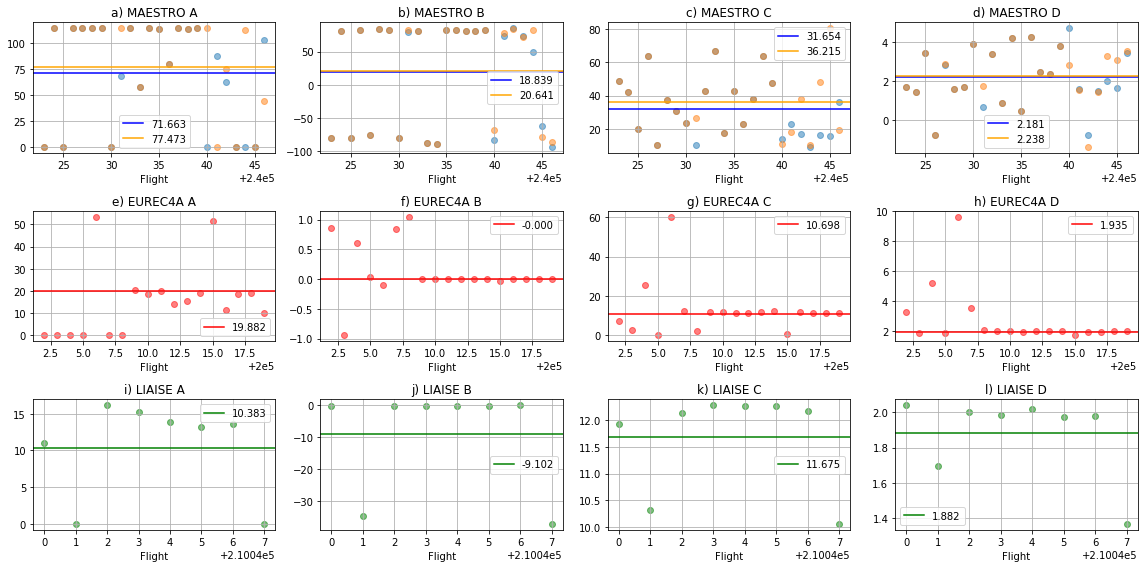

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(16, 8), sharex=False)
fac = 180/np.pi
# MAESTRO aoa
axs[0, 0].scatter(df_calib_imu1['flight'], fac*df_calib_imu1['A'], alpha=0.5)
axs[0, 0].scatter(df_calib_imu1['flight'], fac*df_calib_imu2['A'], alpha=0.5)
mean=fac*df_calib_imu1['A'].mean()
axs[0, 0].axhline(y=mean , label=f'{mean:.03f}', color='blue')
mean=fac*df_calib_imu2['A'].mean()
axs[0, 0].axhline(y=mean , label=f'{mean:.03f}', color='orange')
axs[0, 0].set_title('a) MAESTRO A')
axs[0, 0].grid()
axs[0, 0].legend()

# MAESTRO aos
axs[0, 1].scatter(df_calib_imu1['flight'], fac*df_calib_imu1['B'], alpha=0.5)
axs[0, 1].scatter(df_calib_imu1['flight'], fac*df_calib_imu2['B'], alpha=0.5)
mean=fac*df_calib_imu1['B'].mean()
axs[0, 1].axhline(y=mean , label=f'{mean:.03f}', color='blue')
mean=fac*df_calib_imu2['B'].mean()
axs[0, 1].axhline(y=mean , label=f'{mean:.03f}', color='orange')
axs[0, 1].set_title('b) MAESTRO B')
axs[0, 1].grid()
axs[0, 1].legend()

# MAESTRO aoa
axs[0, 2].scatter(df_calib_imu1['flight'], fac*df_calib_imu1['C'], alpha=0.5)
axs[0, 2].scatter(df_calib_imu1['flight'], fac*df_calib_imu2['C'], alpha=0.5)
mean=fac*df_calib_imu1['C'].mean()
axs[0, 2].axhline(y=mean , label=f'{mean:.03f}', color='blue')
mean=fac*df_calib_imu2['C'].mean()
axs[0, 2].axhline(y=mean , label=f'{mean:.03f}', color='orange')
axs[0, 2].set_title('c) MAESTRO C')
axs[0, 2].grid()
axs[0, 2].legend()

# MAESTRO aos
axs[0, 3].scatter(df_calib_imu1['flight'], fac*df_calib_imu1['D'], alpha=0.5)
axs[0, 3].scatter(df_calib_imu1['flight'], fac*df_calib_imu2['D'], alpha=0.5)
mean=fac*df_calib_imu1['D'].mean()
axs[0, 3].axhline(y=mean , label=f'{mean:.03f}', color='blue')
mean=fac*df_calib_imu2['D'].mean()
axs[0, 3].axhline(y=mean , label=f'{mean:.03f}', color='orange')
axs[0, 3].set_title('d) MAESTRO D')
axs[0, 3].grid()
axs[0, 3].legend()

# EUREC4A aoa
axs[1, 0].scatter(df_calib_eureca['flight'], fac*df_calib_eureca['A'], alpha=0.5, color='red')
mean=fac*df_calib_eureca[df_calib_eureca['flight']>200008]['A'].mean()
axs[1, 0].axhline(y=mean , label=f'{mean:.03f}', color='red')
axs[1, 0].set_title('e) EUREC4A A')
axs[1, 0].grid()
axs[1, 0].legend()

# EUREC4A aos
axs[1, 1].scatter(df_calib_eureca['flight'], df_calib_eureca['B'], alpha=0.5, color='red')
mean=df_calib_eureca[df_calib_eureca['flight']>200008]['B'].mean()
axs[1, 1].axhline(y=mean , label=f'{mean:.03f}', color='red')
axs[1, 1].set_title('f) EUREC4A B')
axs[1, 1].grid()
axs[1, 1].legend()

# EUREC4A aoa
axs[1, 2].scatter(df_calib_eureca['flight'], fac*df_calib_eureca['C'], alpha=0.5, color='red')
mean=fac*df_calib_eureca[df_calib_eureca['flight']>200008]['C'].mean()
axs[1, 2].axhline(y=mean , label=f'{mean:.03f}', color='red')
axs[1, 2].set_title('g) EUREC4A C')
axs[1, 2].grid()
axs[1, 2].legend()

# EUREC4A aos
axs[1, 3].scatter(df_calib_eureca['flight'], fac*df_calib_eureca['D'], alpha=0.5, color='red')
mean=fac*df_calib_eureca[df_calib_eureca['flight']>200008]['D'].mean()
axs[1, 3].axhline(y=mean , label=f'{mean:.03f}', color='red')
axs[1, 3].set_title('h) EUREC4A D')
axs[1, 3].grid()
axs[1, 3].legend()

# LIAISE aoa
axs[2, 0].scatter(df_calib_liaise['flight'], fac*df_calib_liaise['A'], alpha=0.5, color='green')
mean=fac*df_calib_liaise['A'].mean()
axs[2, 0].axhline(y=mean , label=f'{mean:.03f}', color='green')
axs[2, 0].set_title('i) LIAISE A')
axs[2, 0].grid()
axs[2, 0].legend()

# LIAISE aos
axs[2, 1].scatter(df_calib_liaise['flight'], fac*df_calib_liaise['B'], alpha=0.5, color='green')
mean=fac*df_calib_liaise['B'].mean()
axs[2, 1].axhline(y=mean , label=f'{mean:.03f}', color='green')
axs[2, 1].set_title('j) LIAISE B')
axs[2, 1].grid()
axs[2, 1].legend()

# LIAISE aoa
axs[2, 2].scatter(df_calib_liaise['flight'], fac*df_calib_liaise['C'], alpha=0.5, color='green')
mean=fac*df_calib_liaise['C'].mean()
axs[2, 2].axhline(y=mean , label=f'{mean:.03f}', color='green')
axs[2, 2].set_title('k) LIAISE C')
axs[2, 2].grid()
axs[2, 2].legend()

# LIAISE aos
axs[2, 3].scatter(df_calib_liaise['flight'], fac*df_calib_liaise['D'], alpha=0.5, color='green')
mean=fac*df_calib_liaise['D'].mean()
axs[2, 3].axhline(y=mean , label=f'{mean:.03f}', color='green')
axs[2, 3].set_title('l) LIAISE D')
axs[2, 3].grid()
axs[2, 3].legend()

# General layout tweaks
for ax in axs.flat:
    ax.set_xlabel('Flight')

plt.tight_layout()
plt.savefig('../../Plots/bias_estimation.png')

In [ ]:
new_model_bias= keras.saving.load_model('LIAISE_reg_model_1002.keras')

In [ ]:
def process_campaign_lstm(campaign, INS, data_root='../../Data'):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []
    print(f"Looking in: {segmentation_dir}")
    print("Files found:", os.listdir(segmentation_dir))

    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        if flight_number is None:
            continue

        try:
            yaml_path = os.path.join(segmentation_dir, fname)

            # Match raw data folder
            matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                                   if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
            if not matching_raw_folder:
                print(f"No raw folder found for {campaign} {INS}")
                continue

            raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
            # Look for any .nc file containing the flight number
            flight_str = f'{flight_number:02d}'
            nc_candidates = [f for f in os.listdir(raw_folder)
                             if f.endswith('.nc') and flight_str in f]
            
            if not nc_candidates:
                print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
                continue
            
            nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
            # print(f"  - Loading NetCDF: {nc_candidates[0]}")

            yaml_data = read_yaml(yaml_path)
            df_raw = load_raw_data(nc_path)Conv1D
            if 'SIDESLIP_RAD' in df_raw.columns:
                df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
            
            U,V,W = wind_computation_bias(df_raw, aoa_bias = -0.01, aos_bias = -0.545)
            df_raw['VERTICAL_WIND']= W
            stat_seg = []
            # Segment mask
            mask_all_segments = pd.Series(False, index=df_raw.index)
            for seg in yaml_data['subsegments']:
                start = pd.to_datetime(seg['start'])
                end = pd.to_datetime(seg['end'])
                mask_all_segments |= (df_raw.index >= start) & (df_raw.index <= end)

            df_prep = df_raw
        
            result = minimize(objective, initial_guess, args=(df_prep,), bounds=bounds, method='L-BFGS-B')
            aoa_bias, aos_bias = result.x
            results.append({
                'flight': flight_number,
                'aoa_bias': aoa_bias ,
                'aos_bias': aos_bias ,
            })
        except Exception as e:
            print(f"❌ Error in flight {flight_number}: {e}")

    return results